In [1]:
import librosa
import numpy as np
import soundfile as sf
import os
from jiwer import wer
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import difflib
from pyctcdecode import build_ctcdecoder

d:\Tugas Akhir\STT-1\speech_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
kenlm python bindings are not installed. Most likely you want to install it using: pip install https://github.com/kpu/kenlm/archive/master.zip
kenlm python bindings are not installed. Most likely you want to install it using: pip install https://github.com/kpu/kenlm/archive/master.zip


In [ ]:
# === CONFIGURATION ===
model_dir = r"D:\Tugas Akhir\wav2vec2-finetuned"
# model_dir = r"D:\Tugas Akhir\Wav2Vec2.0-id-Model"

speakers = {
    "MaleVoice1": "Source/MaleVoice1.wav",
    "MaleVoice2": "Source/MaleVoice2.wav"
}

noise_path = "Source/MaleVoice1.2.wav"
ground_truth_text = """
Selamat pagi rekan-rekan semua
Pertama-tama saya ingin mengucapkan terima kasih atas waktu dan kesempatan yang diberikan kepada saya untuk membawakan presentasi pada hari ini Pada rapat kali ini saya akan membahas mengenai transformasi digital dalam konteks bisnis skala kecil dan menengah atau yang kita kenal dengan sebutan UMKM
Seperti yang kita ketahui bersama saat ini dunia sedang bergerak sangat cepat Teknologi berkembang hampir setiap hari dan perubahan tersebut membawa dampak yang sangat besar terhadap cara bisnis dijalankan Bahkan beberapa sektor bisnis mengalami disruption karena tidak mampu beradaptasi dengan cepat terhadap perubahan yang dibawa oleh digitalisasi
berbicara tentang transformasi digital ada beberapa hal utama yang ingin saya soroti hari ini Pertama mengenai digital presence Saat ini tidak cukup hanya mengandalkan toko fisik UMKM harus memiliki online presence yang kuat baik melalui media sosial marketplace maupun website resmi Mengapa ini penting? Karena konsumen zaman sekarang lebih banyak mencari informasi atau melakukan pembelian melalui platform digital Jika bisnis kita tidak hadir di dunia digital maka kita akan tertinggal
Kedua kita perlu bicara soal penggunaan tools berbasis teknologi dalam operasional bisnis Misalnya penggunaan aplikasi untuk pencatatan keuangan inventory management CRM (Customer Relationship Management) sampai dengan otomatisasi pemasaran atau marketing automation Tools seperti ini memungkinkan kita untuk menjalankan bisnis dengan lebih efisien data-driven dan scalable
Namun ada tantangan besar yang kita hadapi terutama untuk pelaku UMKM di daerah yaitu literasi digital Banyak pelaku usaha yang belum familiar dengan tools digital bahkan masih mengandalkan pencatatan manual menggunakan buku tulis Oleh karena itu perlu adanya capacity building atau pelatihan yang berkelanjutan agar pelaku UMKM tidak hanya mampu mengadopsi teknologi tapi juga menggunakannya secara optimal
Dalam konteks ini saya ingin mengangkat satu studi kasus kecil yang sedang saya kembangkan bersama tim yaitu Expense Monitoring Bot untuk pelaku UMKM Bot ini bekerja melalui platform Telegram dan memungkinkan pengguna mencatat pengeluaran harian mereka dengan mudah hanya melalui ponsel Kita sengaja memilih Telegram karena ringan tidak memakan banyak data dan relatif mudah digunakan oleh masyarakat awam
Fitur-fiturnya cukup sederhana namun efektif: ada input untuk jenis pengeluaran jumlah uang dan tanggal Data akan otomatis tersimpan di Google Spreadsheet yang terhubung melalui Apps Script dan bisa diakses kembali kapan saja oleh pemilik usaha Dengan fitur ini kami berharap bisa membantu pelaku UMKM untuk memiliki habit pencatatan yang baik karena kebanyakan masalah dalam bisnis kecil itu bukan karena penjualannya kurang tetapi karena pengelolaan keuangannya tidak rapi
Selain itu kami juga sedang menjajaki kemungkinan integrasi dengan fitur-fitur tambahan seperti laporan mingguan otomatis visualisasi data pengeluaran serta pengingat harian agar pengguna terbiasa mencatat secara rutin Ini adalah langkah kecil namun bisa menjadi awal dari digitalisasi yang lebih besar
dari sisi business model solusi seperti ini bisa dikembangkan menjadi layanan berbasis freemium Di tahap awal semua fitur dasar bisa digunakan secara gratis namun untuk fitur tambahan seperti laporan keuangan otomatis atau integrasi dengan layanan pembayaran pengguna bisa membayar biaya langganan bulanan yang sangat terjangkau
Sekarang saya ingin membahas bagaimana implementasi teknologi ini bisa berdampak pada efisiensi dan pengambilan keputusan bisnis Dengan adanya data yang terekam dengan rapi pelaku usaha bisa melakukan analisis sederhana: di mana mereka terlalu banyak menghabiskan uang? Apakah biaya operasionalnya sudah sesuai? Apakah perlu menekan biaya tertentu atau menambah stok barang yang lebih laku?
Ini yang kita sebut dengan data-driven decision making Sesuatu yang dulu mungkin hanya bisa dilakukan oleh perusahaan besar dengan software mahal sekarang bisa dilakukan bahkan oleh warung kelontong di desa selama mereka dibekali dengan tools yang tepat
Kita tentu tidak bisa melupakan peran pemerintah dan institusi pendidikan dalam mendorong transformasi digital ini Harus ada kolaborasi antara sektor publik dan swasta serta perguruan tinggi untuk memberikan edukasi akses teknologi dan pendampingan kepada pelaku UMKM
Di Universitas Pertamina misalnya banyak sekali potensi yang bisa dikembangkan oleh mahasiswa terutama yang berasal dari jurusan Teknik Informatika Sistem Informasi dan juga manajemen bisnis Kita bisa mendorong kolaborasi lintas jurusan untuk membuat solusi nyata yang bisa diterapkan di lapangan seperti program Pengabdian kepada Masyarakat yang telah diikuti sebelumnya
Penutup dari saya transformasi digital bukan soal menjadi canggih tetapi tentang bagaimana teknologi bisa membuat bisnis menjadi lebih efektif efisien dan mudah diakses Kita harus mulai dari hal-hal sederhana dan terus belajar dari data yang kita miliki Karena seperti yang kita tahu dalam dunia bisnis saat ini data is the new oil Siapa yang menguasai data dan tahu bagaimana memanfaatkannya dialah yang akan bertahan
Terima kasih atas perhatiannya Jika ada pertanyaan atau diskusi saya persilakan
salam
"""
output_dir = "output_mixed"
os.makedirs(output_dir, exist_ok=True)

In [29]:
from transformers import Wav2Vec2Tokenizer, Wav2Vec2CTCTokenizer
model_dir = r"D:\Tugas Akhir\wav2vec2-finetuned"

tokenizer1 = Wav2Vec2Tokenizer.from_pretrained(model_dir)
print("Vocab size:", tokenizer1.vocab_size)

print(tokenizer1.get_vocab())

tokenizer2 = Wav2Vec2CTCTokenizer(
    vocab_file=r"D:\Tugas Akhir\wav2vec2-finetuned\vocab.json",
    do_lower_case=True
)

print("Vocab size:", tokenizer2.vocab_size)
print(tokenizer2.get_vocab())

tokenizer3 = Wav2Vec2Tokenizer.from_pretrained(r"d:\Tugas Akhir\Wav2Vec2.0-id-Model")
print("Vocab size:", tokenizer3.vocab_size)

print(tokenizer3.get_vocab())


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
d:\Tugas Akhir\STT-1\speech_env\Lib\site-packages\transformers\models\wav2vec2\tokenization_wav2vec2.py:720: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
d:\Tugas Akhir\STT-1\speech_env\Lib\site-packages\transformers\configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
The toke

Vocab size: 28
{'[PAD]': 27, '[UNK]': 26, 'a': 5, 'b': 13, 'c': 16, 'd': 17, 'e': 3, 'f': 12, 'g': 8, 'h': 1, 'i': 23, 'j': 24, 'k': 7, 'l': 11, 'm': 0, 'n': 15, 'o': 19, 'p': 18, 'r': 2, 's': 9, 't': 20, 'u': 25, 'v': 14, 'w': 22, 'x': 10, 'y': 21, 'z': 4, '|': 6, '<s>': 28, '</s>': 29}
Vocab size: 28
{'[PAD]': 27, '[UNK]': 26, 'a': 5, 'b': 13, 'c': 16, 'd': 17, 'e': 3, 'f': 12, 'g': 8, 'h': 1, 'i': 23, 'j': 24, 'k': 7, 'l': 11, 'm': 0, 'n': 15, 'o': 19, 'p': 18, 'r': 2, 's': 9, 't': 20, 'u': 25, 'v': 14, 'w': 22, 'x': 10, 'y': 21, 'z': 4, '|': 6, '<s>': 28, '</s>': 29, '<unk>': 30, '<pad>': 31}
Vocab size: 28
{'m': 0, 'h': 1, 'r': 2, 'e': 3, 'z': 4, 'a': 5, 'k': 7, 'g': 8, 's': 9, 'x': 10, 'l': 11, 'f': 12, 'b': 13, 'v': 14, 'n': 15, 'c': 16, 'd': 17, 'p': 18, 'o': 19, 't': 20, 'y': 21, 'w': 22, 'i': 23, 'j': 24, 'u': 25, '|': 6, '[UNK]': 26, '[PAD]': 27, '<s>': 28, '</s>': 29}


In [5]:
# === LOAD MODEL ===
processor = Wav2Vec2Processor.from_pretrained(model_dir)
model = Wav2Vec2ForCTC.from_pretrained(model_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [6]:
# === HELPER FUNCTIONS ===
def load_audio(path, sr=16000):
    audio, _ = librosa.load(path, sr=sr)
    return audio / np.max(np.abs(audio))  # normalize

def adjust_to_target_dBFS(audio, target_dBFS):
    rms = np.sqrt(np.mean(audio**2))
    current_dBFS = 20 * np.log10(rms + 1e-10)
    delta_dB = target_dBFS - current_dBFS
    factor = 10 ** (delta_dB / 20)
    return audio * factor

# def transcribe(audio_array, sample_rate=16000):
#     inputs = processor(audio_array, sampling_rate=sample_rate, return_tensors="pt", padding=True)
#     input_values = inputs.input_values.to(device)
#     attention_mask = inputs.attention_mask.to(device)
#     with torch.no_grad():
#         logits = model(input_values, attention_mask=attention_mask).logits
#     predicted_ids = torch.argmax(logits, dim=-1)
#     transcription = processor.batch_decode(predicted_ids)[0]
#     return transcription.lower()

In [7]:
# === NEW DECODER SETUP ===

# Ambil vocab asli dari tokenizer
vocab_dict = processor.tokenizer.get_vocab()
sorted_vocab = sorted(vocab_dict.items(), key=lambda item: item[1])
# Batasi vocab hanya sebanyak output dimensi model
vocab = [k if k != processor.tokenizer.word_delimiter_token else ' ' for k, _ in sorted_vocab[:model.lm_head.out_features]]

# Buat decoder dari vocab saja (TANPA language model)
decoder = build_ctcdecoder(vocab)

# === GANTI fungsi transcribe ===
def transcribe(audio_array, sample_rate=16000):
    inputs = processor(audio_array, sampling_rate=sample_rate, return_tensors="pt", padding=True)
    input_values = inputs.input_values.to(device)
    attention_mask = inputs.attention_mask.to(device)
    
    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits

    logits_np = logits[0].cpu().numpy()  # ambil logits dari tensor ke NumPy
    transcription = decoder.decode(logits_np)
    return transcription.lower()

In [8]:
# === LOAD AUDIO ===
narrator = load_audio(narrator_path)
noise = load_audio(noise_path)

# Pad noise if needed
if len(noise) < len(narrator):
    noise = np.tile(noise, int(np.ceil(len(narrator) / len(noise))))
noise = noise[:len(narrator)]

In [9]:
# === NORMALIZE NARRATOR to -20 dBFS (natural speech)
narrator = adjust_to_target_dBFS(narrator, -20)

In [10]:
results = []

In [11]:
# [IDEAL] WER: 0.6180 MaleVoice1
# [IDEAL] WER: 0.5660 MaleVoice2

In [12]:
# === IDEAL ===
text = transcribe(narrator)
error = wer(ground_truth_text.lower(), text)
results.append(("ideal.wav", -20, "ideal", text, error))
sf.write(os.path.join(output_dir, "ideal.wav"), narrator, 16000)
print(f"[IDEAL] WER: {error:.4f}") 

[IDEAL] WER: 0.5660


In [13]:
# === EXPERIMENT WITH DIFFERENT NOISE LEVELS ===
for db in [-35, -30, -25, -20]:  # relative to dBFS
    adjusted_noise = adjust_to_target_dBFS(noise, db)
    mixed = narrator + adjusted_noise
    mixed /= np.max(np.abs(mixed))  # normalize to prevent clipping
    fname = f"whisper_{abs(db)}dBFS.wav"
    fpath = os.path.join(output_dir, fname)
    sf.write(fpath, mixed, 16000)

    text = transcribe(mixed)
    error = wer(ground_truth_text.lower(), text)
    results.append((fname, db, "whisper", text, error))
    print(f"[Noise @ {db} dBFS] WER: {error:.4f}")

[Noise @ -35 dBFS] WER: 0.6840
[Noise @ -30 dBFS] WER: 0.8272
[Noise @ -25 dBFS] WER: 1.0716
[Noise @ -20 dBFS] WER: 1.2584


In [14]:
# === EQUAL RMS NOISE MIX ===
equal_noise = noise * np.sqrt(np.mean(narrator**2) / np.mean(noise**2))
mixed = narrator + equal_noise
mixed /= np.max(np.abs(mixed))
fname = "equal_noise.wav"
fpath = os.path.join(output_dir, fname)
sf.write(fpath, mixed, 16000)
text = transcribe(mixed)
error = wer(ground_truth_text.lower(), text)
results.append((fname, "equal", "equal", text, error))
print(f"[EQUAL RMS] WER: {error:.4f}")

[EQUAL RMS] WER: 1.2584


In [15]:
# === OVERPOWER NOISE ===
db_base = 20 * np.log10(np.sqrt(np.mean(narrator**2)) + 1e-10)
offset = 5
while True:
    db = db_base + offset
    strong_noise = adjust_to_target_dBFS(noise, db)
    mixed = narrator + strong_noise
    mixed /= np.max(np.abs(mixed))

    fname = f"overpower_{int(db)}dBFS.wav"
    fpath = os.path.join(output_dir, fname)
    sf.write(fpath, mixed, 16000)

    text = transcribe(mixed)
    error = wer(ground_truth_text.lower(), text)
    results.append((fname, db, "overpower", text, error))
    print(f"[Overpower @ {db:.1f} dBFS] WER: {error:.4f}")

    if error >= 1 or db >= -5:
        break
    offset += 5

KeyboardInterrupt: 

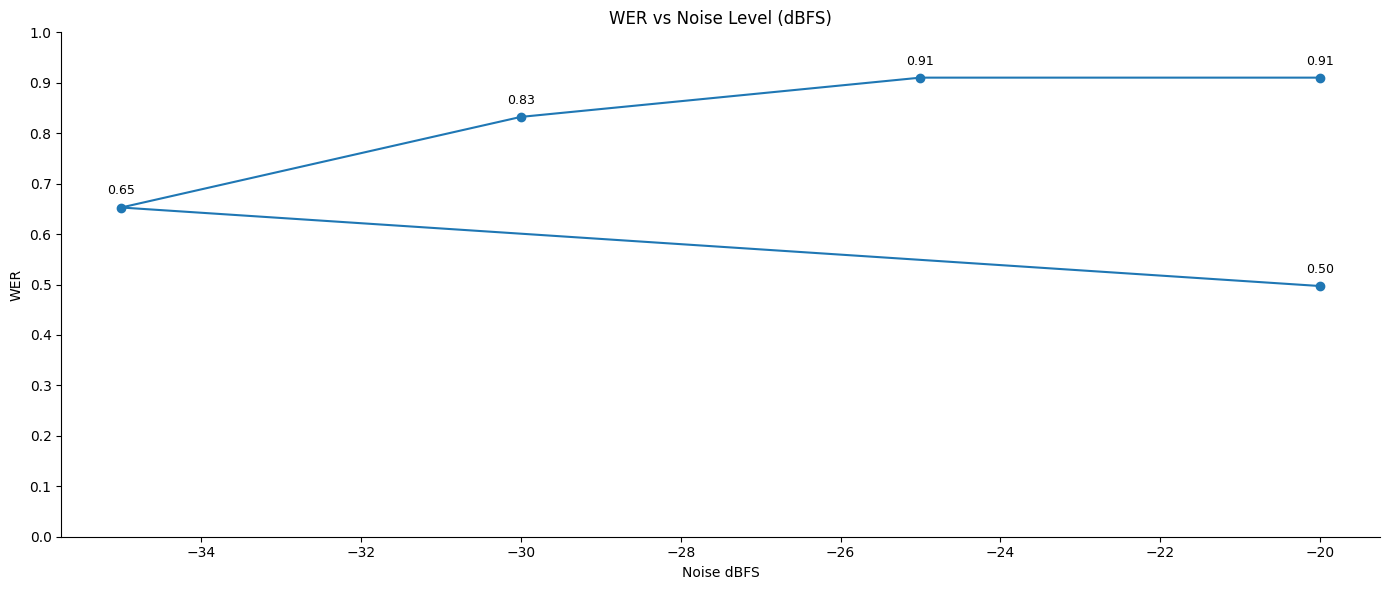

In [ ]:
# === PLOT WER vs NOISE LEVEL ===
dbs = [r[1] for r in results if isinstance(r[1], (int, float))]
wers = [r[4] for r in results if isinstance(r[1], (int, float))]

dbs = [r[1] for r in results if isinstance(r[1], (int, float))]
wers = [r[4] for r in results if isinstance(r[1], (int, float))]

plt.figure(figsize=(14, 6))
plt.plot(dbs, wers, marker='o')

for x, y in zip(dbs, wers):
    plt.text(x, y + 0.02, f"{y:.2f}", ha='center', va='bottom', fontsize=9)

plt.title("WER vs Noise Level (dBFS)")
plt.xlabel("Noise dBFS")
plt.ylabel("WER")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.grid(False)
sns.despine()  # Hilangkan frame atas dan kanan

plt.tight_layout()
plt.show()

In [22]:
def visualize_word_comparison(gt_text, pred_text):
    gt_words = gt_text.lower().split()
    pred_words = pred_text.lower().split()
    matcher = difflib.SequenceMatcher(None, gt_words, pred_words)

    correct_count = 0
    for opcode in matcher.get_opcodes():
        tag, i1, i2, j1, j2 = opcode
        if tag == 'equal':
            correct_count += (i2 - i1)
            for word in gt_words[i1:i2]:
                print(f"\033[92m{word}\033[0m", end=' ')  # green
        elif tag == 'replace':
            print(f"\n\033[91mGT: {' '.join(gt_words[i1:i2])}\033[0m")
            print(f"\033[91mPR: {' '.join(pred_words[j1:j2])}\033[0m")
        elif tag == 'delete':
            print(f"\n\033[91mDEL: {' '.join(gt_words[i1:i2])}\033[0m")
        elif tag == 'insert':
            print(f"\n\033[93mINS: {' '.join(pred_words[j1:j2])}\033[0m")
    print()

    total_words = len(gt_words)
    accuracy = correct_count / total_words if total_words > 0 else 0
    print(f"\nCorrect words: {correct_count} / {total_words} ({accuracy:.2%})")
    return correct_count, total_words, accuracy

In [23]:
print("\n=== Perbandingan Kata: Ideal ===")
visualize_word_comparison(ground_truth_text, results[0][3])


=== Perbandingan Kata: Ideal ===

GT: selamat pagi rekan-rekan
PR: selama pagirakan kan
semua 
GT: pertama-tama saya
PR: pertama tama sa
ingin 
GT: mengucapkan
PR: mengucakan
terima 
GT: kasih
PR: kasi
atas waktu 
GT: dan kesempatan yang diberikan kepada
PR: deng kesempai engiberikan kepera
saya untuk membawakan presentasi pada hari ini pada 
GT: rapat
PR: dapat
kali ini saya akan membahas mengenai 
GT: transformasi digital
PR: tran s permasi di gital
dalam konteks bisnis 
GT: skala
PR: kala
kecil dan 
GT: menengah
PR: menenga
atau yang kita kenal dengan sebutan 
GT: umkm
PR: om kaem
seperti yang kita ketahui bersama saat ini dunia sedang 
GT: bergerak sangat cepat teknologi berkembang hampir setiap
PR: begera cangacepat knologi berkembaka ben secap
hari dan perubahan tersebut membawa 
GT: dampak
PR: dam pak
yang sangat besar 
GT: terhadap cara bisnis dijalankan
PR: terkhadacara bisnis di jalan kan
bahkan 
GT: beberapa sektor
PR: beberapaseknar
bisnis mengalami 
GT: disruption
PR: di 

(405, 728, 0.5563186813186813)

In [62]:
with open(output_mixed, newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader)  # Lewati header jika ada
    for row in reader:
        # Misal prediksi ada di kolom ke-4 (index 3), sesuaikan jika beda
        predicted_text = row[3]
        print("\n=== Perbandingan Kata: Prediksi dari CSV ===")
        visualize_word_comparison(ground_truth_text, predicted_text)
        break

NameError: name 'output_mixed' is not defined

In [34]:
for r in results:
    fname, db, scenario, pred, error = r
    print(f"\n=== Scenario: {scenario} | Noise dB: {db} | WER: {error:.4f} ===")
    visualize_word_comparison(ground_truth_text, pred)


=== Scenario: ideal | Noise dB: -20 | WER: 0.4970 ===

GT: pada rapat kali ini
PR: padarapat kalini
kita 
GT: perlu
PR: berlu
fokus pada pencapaian target yang 
GT: sudah disepakati sebelumnya
PR: suda di sepakadisebelumnya
seperti yang kita tahu 
INS: taa
tantangan terbesar yang kita hadapi 
GT: adalah
PR: adalahm
memastikan setiap 
GT: department
PR: depardman
dapat berkolaborasi dengan lebih efektif oleh karena itu penting bagi kita untuk melakukan 
GT: evaluation
PR: evaluesien
terhadap 
GT: strategi
PR: setratgi
yang telah diterapkan dan membuat 
GT: penyesuaian
PR: penyesuain
yang diperlukan 
GT: saya berharap semua
PR: seberharap semuat
tim dapat 
INS: berk
memberikan 
GT: update terbaru
PR: apditerbaru
mengenai progres 
GT: masing-masing thank you so much for your hard work let's keep up the momentum over to you maria can you give us an update on the marketing campaign terima kasih
PR: masing masing teng somac forior hardworg letskibab ti memencum overcuyu moria cano gf as apd

In [24]:
df = pd.DataFrame(results, columns=["Filename", "dB", "Scenario", "Transcription", "WER"])
df.to_csv("output_mixed/experiment_results.csv", index=False)
print(df.head(20))

                Filename         dB   Scenario  \
0              ideal.wav        -20      ideal   
1     whisper_35dBFS.wav        -35    whisper   
2     whisper_30dBFS.wav        -30    whisper   
3     whisper_25dBFS.wav        -25    whisper   
4     whisper_20dBFS.wav        -20    whisper   
5        equal_noise.wav      equal      equal   
6  overpower_-14dBFS.wav -14.999998  overpower   
7   overpower_-9dBFS.wav  -9.999998  overpower   
8   overpower_-4dBFS.wav  -4.999998  overpower   

                                       Transcription       WER  
0  padarapat kalini kita berlu fokus pada pencapa...  0.497006  
1  biajadi pada rapat kalni idap perlu fopus ada ...  0.652695  
2  diajadi padarapatkalini ada perlu faus ada pen...  0.832335  
3  iajadi adarapatkalin aia aberlu fateruh nsaya ...  0.910180  
4  iajadi ara mealsaia berlu faterasaya pencopaya...  0.910180  
5  iajadi ara mealsaia berlu faterasaya pencopaya...  0.910180  
6  biajadi kaalurgal saa berlu paterbiapaya 

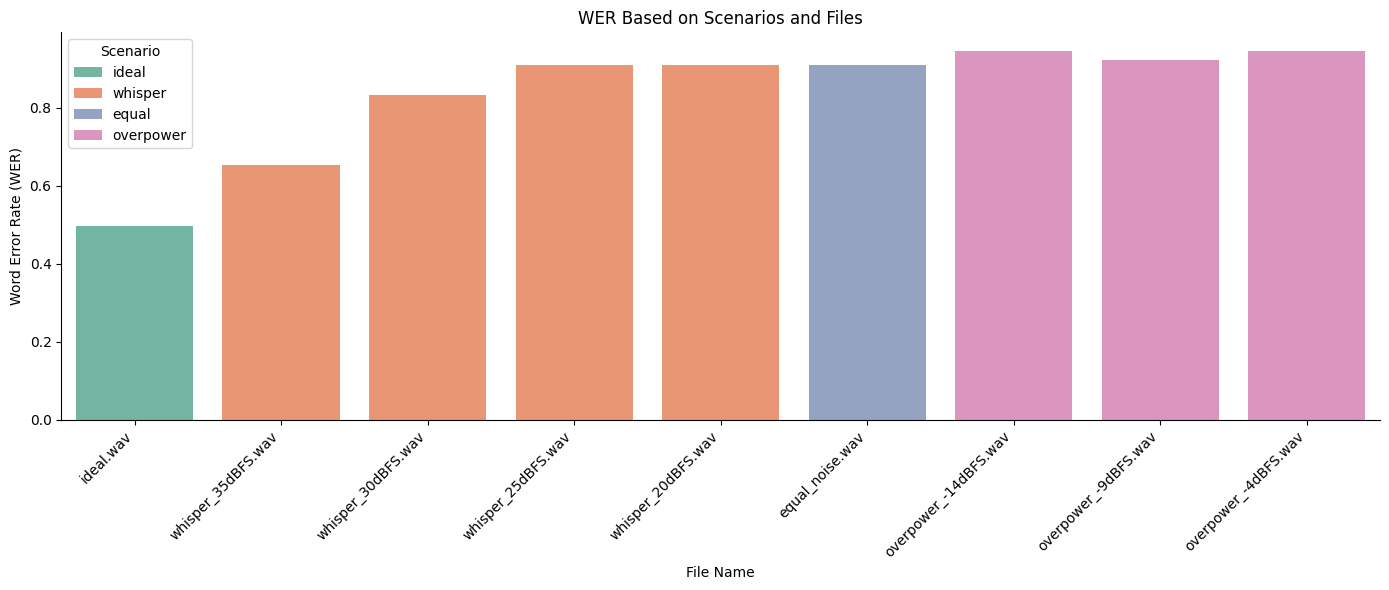

In [36]:
df_plot = df.copy()
df_plot["dB"] = df_plot["dB"].astype(str)

plt.figure(figsize=(14, 6))
sns.barplot(data=df_plot, x="Filename", y="WER", hue="Scenario", dodge=False, palette="Set2")
plt.xticks(rotation=45, ha='right')
plt.title("WER Based on Scenarios and Files")
plt.ylabel("Word Error Rate (WER)")
plt.xlabel("File Name")
sns.despine()
plt.tight_layout()
plt.show()

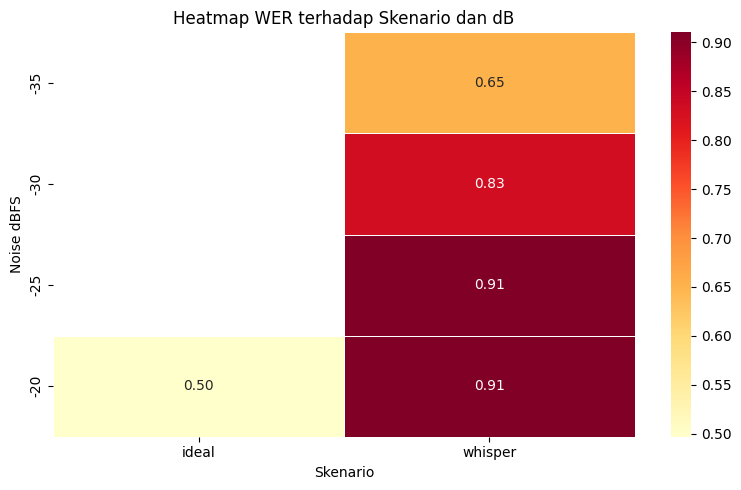

In [26]:
numeric_df = df[df["dB"].apply(lambda x: isinstance(x, (int, float)))]
pivot_df = numeric_df.pivot(index="dB", columns="Scenario", values="WER").sort_index()

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_df, annot=True, cmap="YlOrRd", fmt=".2f", linewidths=0.5)
plt.title("Heatmap WER terhadap Skenario dan dB")
plt.xlabel("Skenario")
plt.ylabel("Noise dBFS")
plt.tight_layout()
plt.show()

C:\Users\dephm\AppData\Local\Temp\ipykernel_23892\1309953431.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Scenario", y="WER", palette="pastel")


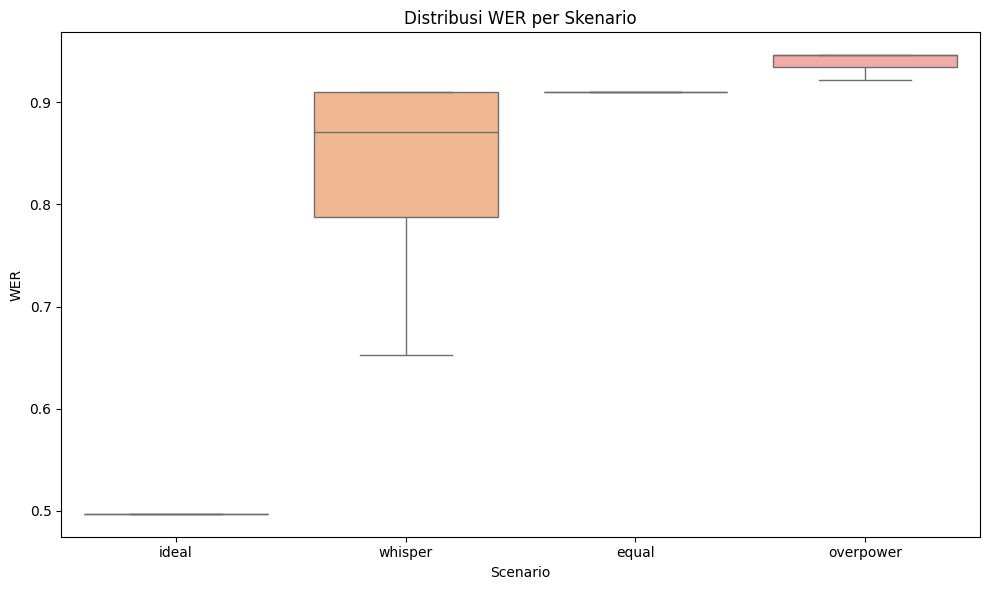

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Scenario", y="WER", palette="pastel")
plt.title("Distribusi WER per Skenario")
plt.tight_layout()
plt.show()

In [18]:
def plot_waveform(audio, color='gray', sr=16000):
    plt.figure(figsize=(10, 3))
    times = np.arange(len(audio)) / sr
    plt.plot(times, audio, color=color)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    sns.despine()
    plt.show()


Waveform: ideal.wav


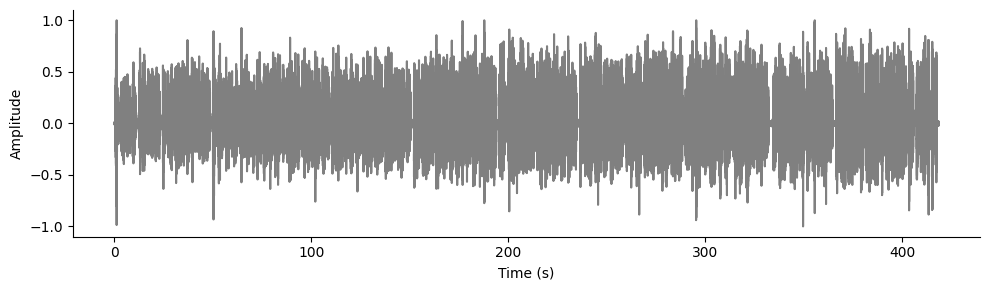

Waveform: whisper_35dBFS.wav


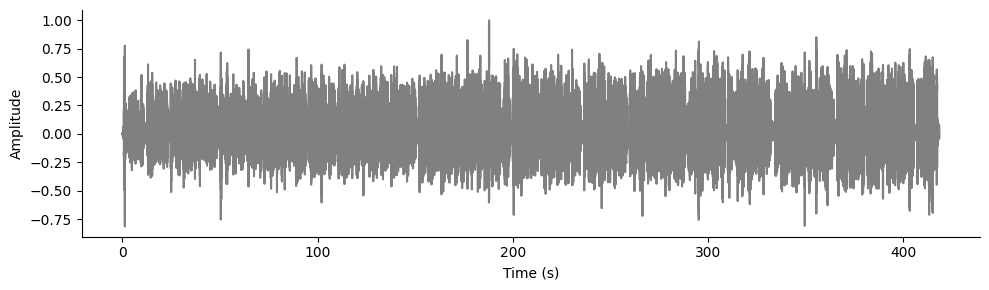

Waveform: whisper_30dBFS.wav


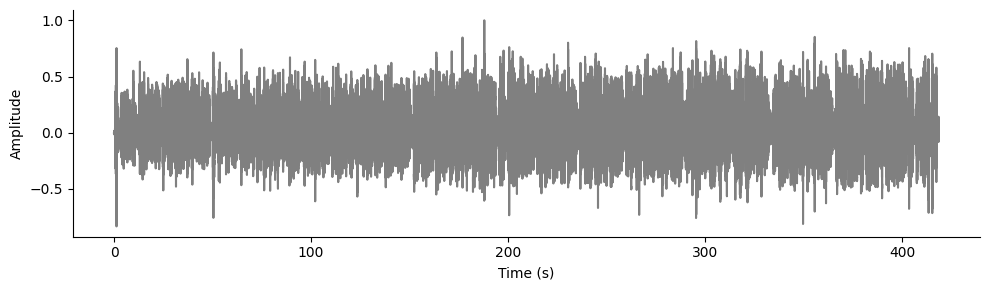

Waveform: whisper_25dBFS.wav


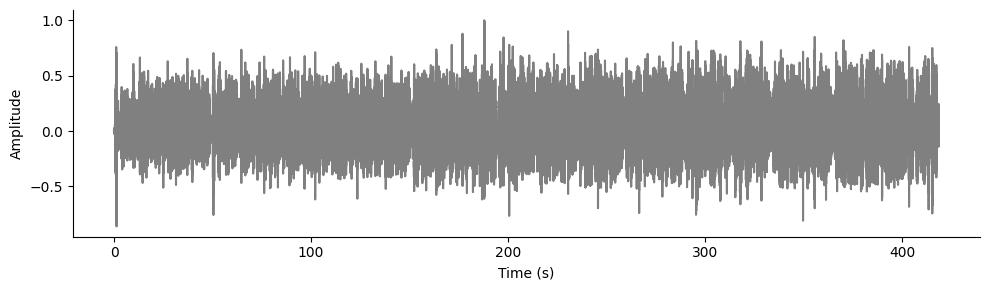

Waveform: whisper_20dBFS.wav


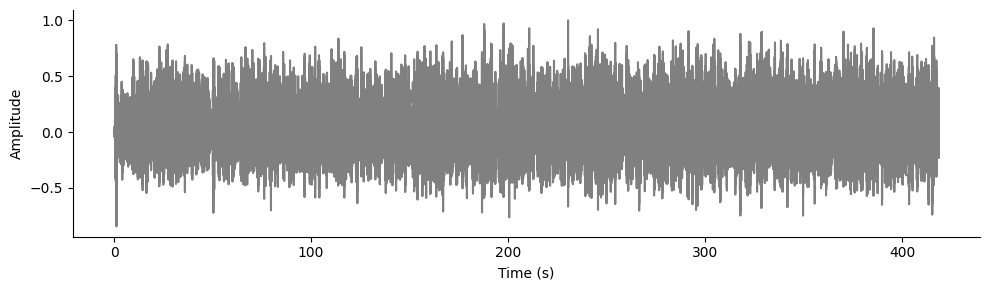

Waveform: equal_noise.wav


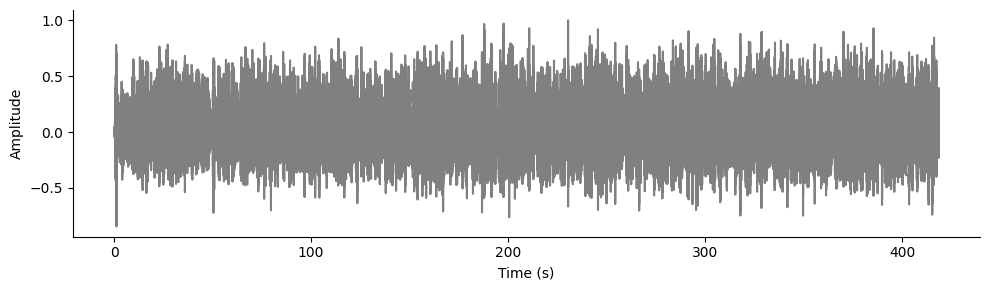

In [19]:
# Plot untuk masing-masing file hasil eksperimen
for fname, _, _, _, _ in results:
    fpath = os.path.join(output_dir, fname)
    if os.path.exists(fpath):
        print(f"Waveform: {fname}")  # Cetak judul di luar
        audio, _ = librosa.load(fpath, sr=16000)
        plot_waveform(audio)

In [20]:
def overlay_waveform(main_audio, noise_audio, sr=16000):
    plt.figure(figsize=(10, 3))
    times = np.arange(len(main_audio)) / sr
    plt.plot(times, main_audio, label='Narasumber', color='dimgray', alpha=0.9)
    plt.plot(times, noise_audio, label='Noise', color='lightgray', alpha=0.6)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    sns.despine()
    plt.show()

Overlay: whisper @ -35 dBFS


C:\Users\dephm\AppData\Local\Temp\ipykernel_17704\3745113305.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


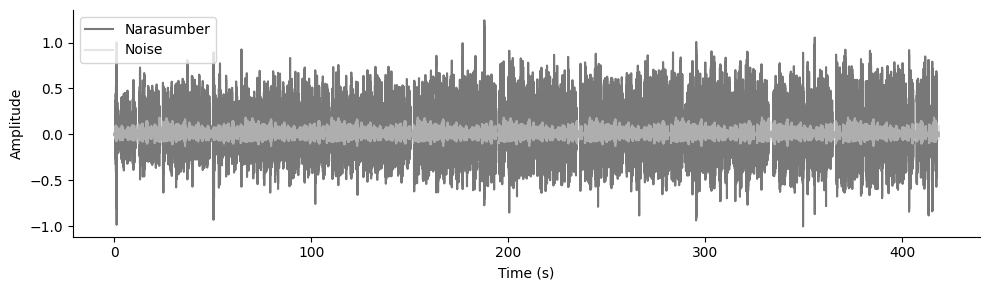

Overlay: whisper @ -30 dBFS


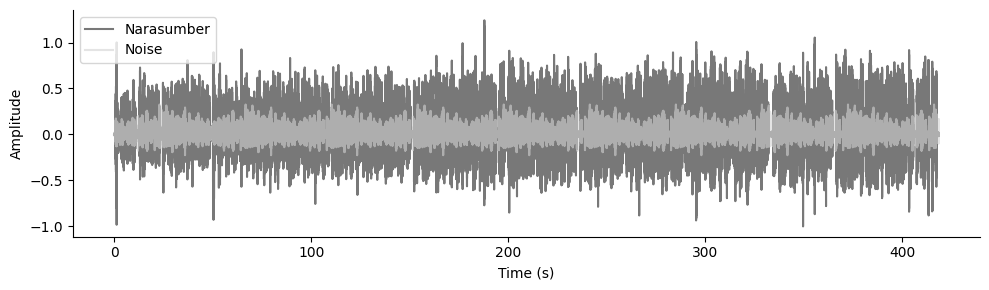

Overlay: whisper @ -25 dBFS


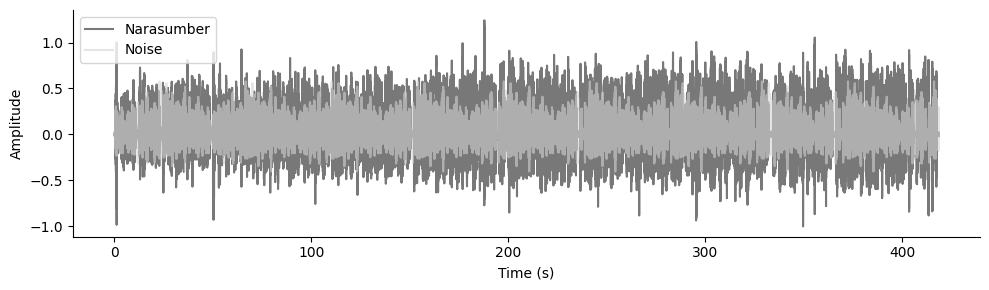

Overlay: whisper @ -20 dBFS


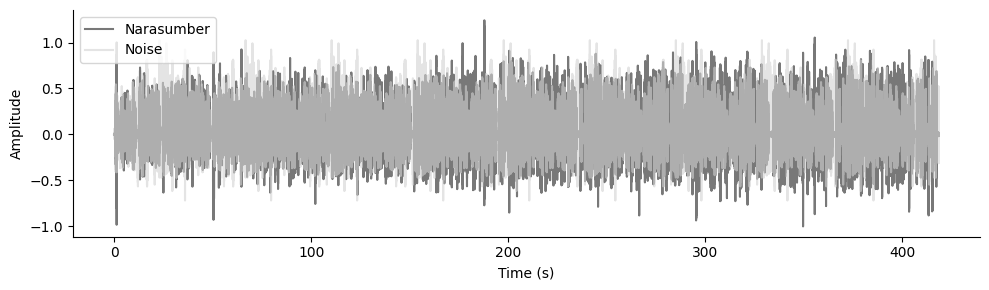

Overlay: equal @ equal dBFS


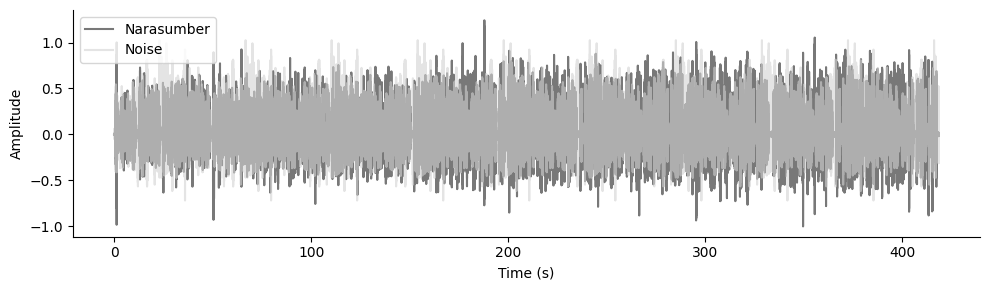

In [21]:
# Overlay untuk semua skenario selain ideal
for fname, db, scenario, _, _ in results:
    if scenario == "ideal":
        continue
    fpath = os.path.join(output_dir, fname)
    if os.path.exists(fpath):
        print(f"Overlay: {scenario} @ {db} dBFS")  # Cetak judul di luar
        mixed, _ = librosa.load(fpath, sr=16000)

        # Rekonstruksi ulang noise sesuai skenario
        if scenario == "whisper":
            noise_db = db
            noise_adjusted = adjust_to_target_dBFS(noise, noise_db)
        elif scenario == "equal":
            noise_adjusted = noise * np.sqrt(np.mean(narrator**2) / np.mean(noise**2))
        elif scenario == "overpower":
            noise_adjusted = adjust_to_target_dBFS(noise, db)
        else:
            continue

        overlay_waveform(narrator, noise_adjusted[:len(narrator)])


In [33]:
for speaker_name, path in speakers.items():
    narrator = load_audio(path)
    narrator = adjust_to_target_dBFS(narrator, -20)

    # === IDEAL ===
    text = transcribe(narrator)
    error = wer(ground_truth_text.lower(), text)
    results.append((f"{speaker_name}_ideal.wav", -20, "ideal", speaker_name, text, error))
    sf.write(os.path.join(output_dir, f"{speaker_name}_ideal.wav"), narrator, 16000)
    print(f"[{speaker_name} - IDEAL] WER: {error:.4f}")

    # === EXPERIMENT NOISE ===
    for db in [-35, -30, -25, -20]:
        adjusted_noise = adjust_to_target_dBFS(noise, db)
        mixed = narrator + adjusted_noise
        mixed /= np.max(np.abs(mixed))

        fname = f"{speaker_name}_whisper_{abs(db)}dBFS.wav"
        fpath = os.path.join(output_dir, fname)
        sf.write(fpath, mixed, 16000)

        text = transcribe(mixed)
        error = wer(ground_truth_text.lower(), text)
        results.append((fname, db, "whisper", speaker_name, text, error))
        print(f"[{speaker_name} - Whisper @ {db} dBFS] WER: {error:.4f}")

[MaleVoice1 - IDEAL] WER: 0.6180


ValueError: operands could not be broadcast together with shapes (8503040,) (6696960,) 

In [35]:
for speaker in df["Speaker"].unique():
    ideal_row = df[(df["Speaker"] == speaker) & (df["Scenario"] == "ideal")].iloc[0]
    print(f"\n=== Perbandingan Kata: {speaker} (Ideal) ===")
    visualize_word_comparison(ground_truth_text, ideal_row["Transcription"])

NameError: name 'df' is not defined

In [34]:
from difflib import SequenceMatcher

def compare_two_transcriptions(text1, text2):
    print("\n=== Perbandingan Dua Narasumber (Ideal) ===")
    words1 = text1.lower().split()
    words2 = text2.lower().split()

    matcher = SequenceMatcher(None, words1, words2)

    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            print(f"\033[92m{' '.join(words1[i1:i2])}\033[0m", end=' ')
        elif tag == 'replace':
            print(f"\n\033[91m{words1[i1:i2]} ⇄ {words2[j1:j2]}\033[0m")
        elif tag == 'delete':
            print(f"\n\033[91mDEL: {' '.join(words1[i1:i2])}\033[0m")
        elif tag == 'insert':
            print(f"\n\033[93mINS: {' '.join(words2[j1:j2])}\033[0m")

    print()

# Ambil transkripsi ideal dari dua narasumber
ideal_trans_1 = df[(df["Speaker"] == "MaleVoice1") & (df["Scenario"] == "ideal")]["Transcription"].values[0]
ideal_trans_2 = df[(df["Speaker"] == "MaleVoice2") & (df["Scenario"] == "ideal")]["Transcription"].values[0]
compare_two_transcriptions(ideal_trans_1, ideal_trans_2)

NameError: name 'df' is not defined

In [ ]:
df.to_csv(os.path.join(output_dir, "experiment_results_by_speaker.csv"), index=False)

In [4]:
import librosa
import numpy as np
import soundfile as sf
import os
from jiwer import wer
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import difflib
from pyctcdecode import build_ctcdecoder
# === CONFIGURATION ===
model_dir = r"D:\Tugas Akhir\wav2vec2-finetuned"
# model_dir = r"D:\Tugas Akhir\Wav2Vec2.0-id-Model"

speakers = {
    "MaleVoice1": "Source/MaleVoice1.wav",
    "MaleVoice2": "Source/MaleVoice2.wav"
}

noise_path = "Source/MaleVoice1.2.wav"
ground_truth_text = """
Selamat pagi rekan-rekan semua
Pertama-tama saya ingin mengucapkan terima kasih atas waktu dan kesempatan yang diberikan kepada saya untuk membawakan presentasi pada hari ini Pada rapat kali ini saya akan membahas mengenai transformasi digital dalam konteks bisnis skala kecil dan menengah atau yang kita kenal dengan sebutan UMKM
Seperti yang kita ketahui bersama saat ini dunia sedang bergerak sangat cepat Teknologi berkembang hampir setiap hari dan perubahan tersebut membawa dampak yang sangat besar terhadap cara bisnis dijalankan Bahkan beberapa sektor bisnis mengalami disruption karena tidak mampu beradaptasi dengan cepat terhadap perubahan yang dibawa oleh digitalisasi
berbicara tentang transformasi digital ada beberapa hal utama yang ingin saya soroti hari ini Pertama mengenai digital presence Saat ini tidak cukup hanya mengandalkan toko fisik UMKM harus memiliki online presence yang kuat baik melalui media sosial marketplace maupun website resmi Mengapa ini penting? Karena konsumen zaman sekarang lebih banyak mencari informasi atau melakukan pembelian melalui platform digital Jika bisnis kita tidak hadir di dunia digital maka kita akan tertinggal
Kedua kita perlu bicara soal penggunaan tools berbasis teknologi dalam operasional bisnis Misalnya penggunaan aplikasi untuk pencatatan keuangan inventory management CRM (Customer Relationship Management) sampai dengan otomatisasi pemasaran atau marketing automation Tools seperti ini memungkinkan kita untuk menjalankan bisnis dengan lebih efisien data-driven dan scalable
Namun ada tantangan besar yang kita hadapi terutama untuk pelaku UMKM di daerah yaitu literasi digital Banyak pelaku usaha yang belum familiar dengan tools digital bahkan masih mengandalkan pencatatan manual menggunakan buku tulis Oleh karena itu perlu adanya capacity building atau pelatihan yang berkelanjutan agar pelaku UMKM tidak hanya mampu mengadopsi teknologi tapi juga menggunakannya secara optimal
Dalam konteks ini saya ingin mengangkat satu studi kasus kecil yang sedang saya kembangkan bersama tim yaitu Expense Monitoring Bot untuk pelaku UMKM Bot ini bekerja melalui platform Telegram dan memungkinkan pengguna mencatat pengeluaran harian mereka dengan mudah hanya melalui ponsel Kita sengaja memilih Telegram karena ringan tidak memakan banyak data dan relatif mudah digunakan oleh masyarakat awam
Fitur-fiturnya cukup sederhana namun efektif: ada input untuk jenis pengeluaran jumlah uang dan tanggal Data akan otomatis tersimpan di Google Spreadsheet yang terhubung melalui Apps Script dan bisa diakses kembali kapan saja oleh pemilik usaha Dengan fitur ini kami berharap bisa membantu pelaku UMKM untuk memiliki habit pencatatan yang baik karena kebanyakan masalah dalam bisnis kecil itu bukan karena penjualannya kurang tetapi karena pengelolaan keuangannya tidak rapi
Selain itu kami juga sedang menjajaki kemungkinan integrasi dengan fitur-fitur tambahan seperti laporan mingguan otomatis visualisasi data pengeluaran serta pengingat harian agar pengguna terbiasa mencatat secara rutin Ini adalah langkah kecil namun bisa menjadi awal dari digitalisasi yang lebih besar
dari sisi business model solusi seperti ini bisa dikembangkan menjadi layanan berbasis freemium Di tahap awal semua fitur dasar bisa digunakan secara gratis namun untuk fitur tambahan seperti laporan keuangan otomatis atau integrasi dengan layanan pembayaran pengguna bisa membayar biaya langganan bulanan yang sangat terjangkau
Sekarang saya ingin membahas bagaimana implementasi teknologi ini bisa berdampak pada efisiensi dan pengambilan keputusan bisnis Dengan adanya data yang terekam dengan rapi pelaku usaha bisa melakukan analisis sederhana: di mana mereka terlalu banyak menghabiskan uang? Apakah biaya operasionalnya sudah sesuai? Apakah perlu menekan biaya tertentu atau menambah stok barang yang lebih laku?
Ini yang kita sebut dengan data-driven decision making Sesuatu yang dulu mungkin hanya bisa dilakukan oleh perusahaan besar dengan software mahal sekarang bisa dilakukan bahkan oleh warung kelontong di desa selama mereka dibekali dengan tools yang tepat
Kita tentu tidak bisa melupakan peran pemerintah dan institusi pendidikan dalam mendorong transformasi digital ini Harus ada kolaborasi antara sektor publik dan swasta serta perguruan tinggi untuk memberikan edukasi akses teknologi dan pendampingan kepada pelaku UMKM
Di Universitas Pertamina misalnya banyak sekali potensi yang bisa dikembangkan oleh mahasiswa terutama yang berasal dari jurusan Teknik Informatika Sistem Informasi dan juga manajemen bisnis Kita bisa mendorong kolaborasi lintas jurusan untuk membuat solusi nyata yang bisa diterapkan di lapangan seperti program Pengabdian kepada Masyarakat yang telah diikuti sebelumnya
Penutup dari saya transformasi digital bukan soal menjadi canggih tetapi tentang bagaimana teknologi bisa membuat bisnis menjadi lebih efektif efisien dan mudah diakses Kita harus mulai dari hal-hal sederhana dan terus belajar dari data yang kita miliki Karena seperti yang kita tahu dalam dunia bisnis saat ini data is the new oil Siapa yang menguasai data dan tahu bagaimana memanfaatkannya dialah yang akan bertahan
Terima kasih atas perhatiannya Jika ada pertanyaan atau diskusi saya persilakan
salam
"""
output_dir = "output_mixed2"
os.makedirs(output_dir, exist_ok=True)
# === LOAD MODEL ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = Wav2Vec2Processor.from_pretrained(model_dir)
model = Wav2Vec2ForCTC.from_pretrained(model_dir).to(device)
# === VOCAB & DECODER ===
vocab_dict = processor.tokenizer.get_vocab()
sorted_vocab = sorted(vocab_dict.items(), key=lambda item: item[1])
vocab = [k if k != processor.tokenizer.word_delimiter_token else ' ' for k, _ in sorted_vocab[:model.lm_head.out_features]]
decoder = build_ctcdecoder(vocab)
# === HELPER FUNCTIONS ===
def load_audio(path, sr=16000):
    audio, _ = librosa.load(path, sr=sr)
    return audio / np.max(np.abs(audio))

def adjust_to_target_dBFS(audio, target_dBFS):
    rms = np.sqrt(np.mean(audio ** 2))
    current_dBFS = 20 * np.log10(rms + 1e-10)
    delta_dB = target_dBFS - current_dBFS
    return audio * (10 ** (delta_dB / 20))

def transcribe(audio_array, sample_rate=16000):
    inputs = processor(audio_array, sampling_rate=sample_rate, return_tensors="pt", padding=True)
    input_values = inputs.input_values.to(device)
    attention_mask = inputs.attention_mask.to(device)
    
    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits
    logits_np = logits[0].cpu().numpy()
    transcription = decoder.decode(logits_np)
    return transcription.lower()
def plot_waveform_overlay(narrator, noise, save_path=None, show_legend=True, title=None):
    plt.figure(figsize=(14, 3))
    times = np.linspace(0, len(narrator) / 16000, num=len(narrator))
    
    plt.plot(times, narrator, color="dimgray", label="Narasumber", alpha=0.9)
    if show_legend:
        plt.plot(times, noise, color="lightgray", label="Noise", alpha=0.6)

    plt.xlabel("Waktu (detik)")
    plt.ylabel("Amplitudo")
    
    if show_legend:
        plt.legend(loc="upper right")
    
    # Hilangkan bar atas dan kanan
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if title:
        plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved: {save_path}")
    plt.close() 
    
def spl_to_dbfs(spl):
    return -20.0 - (65.0 - spl)
whisper_spl = [30, 35, 40, 45]  # SPL
whisper_dbfs = [spl_to_dbfs(s) for s in whisper_spl]

In [5]:
results = []

for speaker_name, narrator_path in speakers.items():
    print(f"\n=== Processing Speaker: {speaker_name} ===")
    
    narrator = load_audio(narrator_path)
    narrator = adjust_to_target_dBFS(narrator, -20)

    # Pad noise
    noise = load_audio(noise_path)
    if len(noise) < len(narrator):
        noise = np.tile(noise, int(np.ceil(len(narrator) / len(noise))))
    noise = noise[:len(narrator)]

    # Ideal
    text = transcribe(narrator)
    error = wer(ground_truth_text.lower(), text)
    results.append(("ideal.wav", -20, "ideal", text, error, speaker_name))
    sf.write(os.path.join(output_dir, f"{speaker_name}_ideal.wav"), narrator, 16000)
    print(f"[{speaker_name}] [IDEAL] WER: {error:.4f}")

    plot_waveform_overlay(narrator, np.zeros_like(narrator),
    title=None,
    save_path=os.path.join(output_dir, f"{speaker_name}_ideal_waveform.png"),
    show_legend=False)


    # Whisper noise
    for spl, db in zip(whisper_spl, whisper_dbfs):
        adjusted_noise = adjust_to_target_dBFS(noise, db)
        mixed = narrator + adjusted_noise
        mixed /= np.max(np.abs(mixed))
        fname = f"{speaker_name}_whisper_{db:.1f}dBFS.wav"
        fpath = os.path.join(output_dir, fname)
        sf.write(fpath, mixed, 16000)

        text = transcribe(mixed)
        error = wer(ground_truth_text.lower(), text)
        results.append((fname, db, spl, "whisper", text, error, speaker_name))
        print(f"[{speaker_name}] [Whisper @ {db}] WER: {error:.4f}")
        
        plot_waveform_overlay(narrator, adjusted_noise, save_path=os.path.join(output_dir, f"{speaker_name}_whisper_{abs(db)}dBFS_waveform.png"), show_legend=True)


    # Equal RMS
    equal_noise = noise * np.sqrt(np.mean(narrator**2) / np.mean(noise**2))
    mixed = narrator + equal_noise
    mixed /= np.max(np.abs(mixed))
    fname = f"{speaker_name}_equal.wav"
    fpath = os.path.join(output_dir, fname)
    sf.write(fpath, mixed, 16000)
    text = transcribe(mixed)
    error = wer(ground_truth_text.lower(), text)
    results.append((fname, "equal", "equal", text, error, speaker_name))
    print(f"[{speaker_name}] [Equal RMS] WER: {error:.4f}")
    plot_waveform_overlay(narrator, equal_noise,
                      save_path=os.path.join(output_dir, f"{speaker_name}_equal_waveform.png"), show_legend=True)


    # Overpower
    db_base = 20 * np.log10(np.sqrt(np.mean(narrator**2)) + 1e-10)
    offset = 5
    while True:
        db = db_base + offset
        strong_noise = adjust_to_target_dBFS(noise, db)
        mixed = narrator + strong_noise
        mixed /= np.max(np.abs(mixed))
        fname = f"{speaker_name}_overpower_{int(db)}dBFS.wav"
        fpath = os.path.join(output_dir, fname)
        sf.write(fpath, mixed, 16000)
        text = transcribe(mixed)
        error = wer(ground_truth_text.lower(), text)
        results.append((fname, db, "overpower", text, error, speaker_name))
        print(f"[{speaker_name}] [Overpower @ {db:.1f} dBFS] WER: {error:.4f}")
        if error >= 1 or db >= -5:
            break
        offset += 5
        plot_waveform_overlay(narrator, strong_noise, save_path=os.path.join(output_dir, f"{speaker_name}_overpower_{int(db)}dBFS_waveform.png"), show_legend=True)
        # 137m 11.4s


=== Processing Speaker: MaleVoice1 ===
[MaleVoice1] [IDEAL] WER: 0.6180
Saved: output_mixed2\MaleVoice1_ideal_waveform.png
[MaleVoice1] [Whisper @ -55.0] WER: 0.6222
Saved: output_mixed2\MaleVoice1_whisper_55.0dBFS_waveform.png
[MaleVoice1] [Whisper @ -50.0] WER: 0.6236
Saved: output_mixed2\MaleVoice1_whisper_50.0dBFS_waveform.png
[MaleVoice1] [Whisper @ -45.0] WER: 0.6362
Saved: output_mixed2\MaleVoice1_whisper_45.0dBFS_waveform.png
[MaleVoice1] [Whisper @ -40.0] WER: 0.6770
Saved: output_mixed2\MaleVoice1_whisper_40.0dBFS_waveform.png
[MaleVoice1] [Equal RMS] WER: 1.6404
Saved: output_mixed2\MaleVoice1_equal_waveform.png
[MaleVoice1] [Overpower @ -15.0 dBFS] WER: 1.6124

=== Processing Speaker: MaleVoice2 ===
[MaleVoice2] [IDEAL] WER: 0.5660
Saved: output_mixed2\MaleVoice2_ideal_waveform.png
[MaleVoice2] [Whisper @ -55.0] WER: 0.5618
Saved: output_mixed2\MaleVoice2_whisper_55.0dBFS_waveform.png
[MaleVoice2] [Whisper @ -50.0] WER: 0.5562
Saved: output_mixed2\MaleVoice2_whisper_50.0dB

KeyboardInterrupt: 

In [8]:
results = []

for speaker_name, narrator_path in speakers.items():
    print(f"\n=== Processing Speaker: {speaker_name} ===")
    
    narrator = load_audio(narrator_path)
    narrator = adjust_to_target_dBFS(narrator, -20)

    # Pad noise
    noise = load_audio(noise_path)
    if len(noise) < len(narrator):
        noise = np.tile(noise, int(np.ceil(len(narrator) / len(noise))))
    noise = noise[:len(narrator)]

    # Ideal
    text = transcribe(narrator)
    error = wer(ground_truth_text.lower(), text)
    results.append(("ideal.wav", -20, "ideal", text, error, speaker_name))
    sf.write(os.path.join(output_dir, f"{speaker_name}_ideal.wav"), narrator, 16000)
    print(f"[{speaker_name}] [IDEAL] WER: {error:.4f}")
    plot_waveform_overlay(narrator, np.zeros_like(narrator), title=None, save_path=os.path.join(output_dir, f"{speaker_name}_ideal_waveform.png"), show_legend=False)


    # Whisper noise
    for spl, db in zip(whisper_spl, whisper_dbfs):
        adjusted_noise = adjust_to_target_dBFS(noise, db)
        mixed = narrator + adjusted_noise
        mixed /= np.max(np.abs(mixed))
        fname = f"{speaker_name}_whisper_{db:.1f}dBFS.wav"
        fpath = os.path.join(output_dir, fname)
        sf.write(fpath, mixed, 16000)

        text = transcribe(mixed)
        error = wer(ground_truth_text.lower(), text)
        results.append((fname, db, spl, "whisper", text, error, speaker_name))
        print(f"[{speaker_name}] [Whisper @ {db}] WER: {error:.4f}")
        plot_waveform_overlay(narrator, adjusted_noise, save_path=os.path.join(output_dir, f"{speaker_name}_whisper_{abs(db)}dBFS_waveform.png"), show_legend=True)


    # Equal RMS
    equal_noise = noise * np.sqrt(np.mean(narrator**2) / np.mean(noise**2))
    mixed = narrator + equal_noise
    mixed /= np.max(np.abs(mixed))
    fname = f"{speaker_name}_equal.wav"
    fpath = os.path.join(output_dir, fname)
    sf.write(fpath, mixed, 16000)
    text = transcribe(mixed)
    error = wer(ground_truth_text.lower(), text)
    results.append((fname, "equal", "equal", text, error, speaker_name))
    print(f"[{speaker_name}] [Equal RMS] WER: {error:.4f}")
    plot_waveform_overlay(narrator, equal_noise, save_path=os.path.join(output_dir, f"{speaker_name}_equal_waveform.png"), show_legend=True)


    # Overpower
    db_base = 20 * np.log10(np.sqrt(np.mean(narrator**2)) + 1e-10)
    offset = 5
    while True:
        db = db_base + offset
        strong_noise = adjust_to_target_dBFS(noise, db)
        mixed = narrator + strong_noise
        mixed /= np.max(np.abs(mixed))
        fname = f"{speaker_name}_overpower_{int(db)}dBFS.wav"
        fpath = os.path.join(output_dir, fname)
        sf.write(fpath, mixed, 16000)
        text = transcribe(mixed)
        error = wer(ground_truth_text.lower(), text)
        results.append((fname, db, "overpower", text, error, speaker_name))
        print(f"[{speaker_name}] [Overpower @ {db:.1f} dBFS] WER: {error:.4f}")
        if error >= 1 or db >= -5:
            break
        offset += 5
        plot_waveform_overlay(narrator, strong_noise, save_path=os.path.join(output_dir, f"{speaker_name}_overpower_{int(db)}dBFS_waveform.png"), show_legend=True)
        # 117 min 57.2s


=== Processing Speaker: MaleVoice1 ===
[MaleVoice1] [IDEAL] WER: 0.6180
Saved: output_mixed2\MaleVoice1_ideal_waveform.png
[MaleVoice1] [Whisper @ -55.0] WER: 0.6222
Saved: output_mixed2\MaleVoice1_whisper_55.0dBFS_waveform.png
[MaleVoice1] [Whisper @ -50.0] WER: 0.6236
Saved: output_mixed2\MaleVoice1_whisper_50.0dBFS_waveform.png
[MaleVoice1] [Whisper @ -45.0] WER: 0.6362
Saved: output_mixed2\MaleVoice1_whisper_45.0dBFS_waveform.png
[MaleVoice1] [Whisper @ -40.0] WER: 0.6770
Saved: output_mixed2\MaleVoice1_whisper_40.0dBFS_waveform.png
[MaleVoice1] [Equal RMS] WER: 1.6404
Saved: output_mixed2\MaleVoice1_equal_waveform.png
[MaleVoice1] [Overpower @ -15.0 dBFS] WER: 1.6124

=== Processing Speaker: MaleVoice2 ===
[MaleVoice2] [IDEAL] WER: 0.5660
Saved: output_mixed2\MaleVoice2_ideal_waveform.png
[MaleVoice2] [Whisper @ -55.0] WER: 0.5618
Saved: output_mixed2\MaleVoice2_whisper_55.0dBFS_waveform.png
[MaleVoice2] [Whisper @ -50.0] WER: 0.5562
Saved: output_mixed2\MaleVoice2_whisper_50.0dB

In [15]:
results = []

for i, (speaker_name, narrator_path) in enumerate(speakers.items()):
    if i != 1:
        continue
    
    print(f"\n=== Processing Speaker: {speaker_name} ===")
    narrator = load_audio(narrator_path)
    narrator = adjust_to_target_dBFS(narrator, -20)

    # Pad noise
    noise = load_audio(noise_path)
    if len(noise) < len(narrator):
        noise = np.tile(noise, int(np.ceil(len(narrator) / len(noise))))
    noise = noise[:len(narrator)]

    # Ideal
    text = transcribe(narrator)
    error = wer(ground_truth_text.lower(), text)
    results.append(("ideal.wav", -20, "ideal", text, error, speaker_name))
    sf.write(os.path.join(output_dir, f"{speaker_name}_ideal.wav"), narrator, 16000)
    print(f"[{speaker_name}] [IDEAL] WER: {error:.4f}")
    plot_waveform_overlay(narrator, np.zeros_like(narrator), title=None, save_path=os.path.join(output_dir, f"{speaker_name}_ideal_waveform.png"), show_legend=False)


    # Whisper noise
    for spl, db in zip(whisper_spl, whisper_dbfs):
        adjusted_noise = adjust_to_target_dBFS(noise, db)
        mixed = narrator + adjusted_noise
        mixed /= np.max(np.abs(mixed))
        fname = f"{speaker_name}_whisper_{db:.1f}dBFS.wav"
        fpath = os.path.join(output_dir, fname)
        sf.write(fpath, mixed, 16000)

        text = transcribe(mixed)
        error = wer(ground_truth_text.lower(), text)
        results.append((fname, db, spl, "whisper", text, error, speaker_name))
        print(f"[{speaker_name}] [Whisper @ {db}] WER: {error:.4f}")
        plot_waveform_overlay(narrator, adjusted_noise, save_path=os.path.join(output_dir, f"{speaker_name}_whisper_{abs(db)}dBFS_waveform.png"), show_legend=True)


    # Equal RMS
    equal_noise = noise * np.sqrt(np.mean(narrator**2) / np.mean(noise**2))
    mixed = narrator + equal_noise
    mixed /= np.max(np.abs(mixed))
    fname = f"{speaker_name}_equal.wav"
    fpath = os.path.join(output_dir, fname)
    sf.write(fpath, mixed, 16000)
    text = transcribe(mixed)
    error = wer(ground_truth_text.lower(), text)
    results.append((fname, "equal", "equal", text, error, speaker_name))
    print(f"[{speaker_name}] [Equal RMS] WER: {error:.4f}")
    plot_waveform_overlay(narrator, equal_noise, save_path=os.path.join(output_dir, f"{speaker_name}_equal_waveform.png"), show_legend=True)


    # Overpower
    db_base = 20 * np.log10(np.sqrt(np.mean(narrator**2)) + 1e-10)
    offset = 5
    while True:
        db = db_base + offset
        strong_noise = adjust_to_target_dBFS(noise, db)
        mixed = narrator + strong_noise
        mixed /= np.max(np.abs(mixed))
        fname = f"{speaker_name}_overpower_{int(db)}dBFS.wav"
        fpath = os.path.join(output_dir, fname)
        sf.write(fpath, mixed, 16000)
        text = transcribe(mixed)
        error = wer(ground_truth_text.lower(), text)
        results.append((fname, db, "overpower", text, error, speaker_name))
        print(f"[{speaker_name}] [Overpower @ {db:.1f} dBFS] WER: {error:.4f}")
        if error >= 1 or db >= -5:
            break
        offset += 5
        plot_waveform_overlay(narrator, strong_noise, save_path=os.path.join(output_dir, f"{speaker_name}_overpower_{int(db)}dBFS_waveform.png"), show_legend=True)
        # 51m 13.2s


=== Processing Speaker: MaleVoice2 ===
[MaleVoice2] [IDEAL] WER: 0.5660
Saved: output_mixed2\MaleVoice2_ideal_waveform.png
[MaleVoice2] [Whisper @ -55.0] WER: 0.5618
Saved: output_mixed2\MaleVoice2_whisper_55.0dBFS_waveform.png
[MaleVoice2] [Whisper @ -50.0] WER: 0.5562
Saved: output_mixed2\MaleVoice2_whisper_50.0dBFS_waveform.png
[MaleVoice2] [Whisper @ -45.0] WER: 0.5688
Saved: output_mixed2\MaleVoice2_whisper_45.0dBFS_waveform.png
[MaleVoice2] [Whisper @ -40.0] WER: 0.5730
Saved: output_mixed2\MaleVoice2_whisper_40.0dBFS_waveform.png
[MaleVoice2] [Equal RMS] WER: 1.4354
Saved: output_mixed2\MaleVoice2_equal_waveform.png
[MaleVoice2] [Overpower @ -15.0 dBFS] WER: 1.6587


In [19]:
results = []

for speaker_name, narrator_path in speakers.items():
    print(f"\n=== Processing Speaker: {speaker_name} ===")
    
    narrator = load_audio(narrator_path)
    narrator = adjust_to_target_dBFS(narrator, -20)

    # Pad noise
    noise = load_audio(noise_path)
    if len(noise) < len(narrator):
        noise = np.tile(noise, int(np.ceil(len(narrator) / len(noise))))
    noise = noise[:len(narrator)]

    # Ideal
    text = transcribe(narrator)
    error = wer(ground_truth_text.lower(), text)
    results.append(("ideal.wav", -20, "ideal", text, error, speaker_name))
    sf.write(os.path.join(output_dir, f"{speaker_name}_ideal.wav"), narrator, 16000)
    print(f"[{speaker_name}] [IDEAL] WER: {error:.4f}")

    # plot_waveform_overlay(narrator, np.zeros_like(narrator), title=None, save_path=os.path.join(output_dir, f"{speaker_name}_ideal_waveform.png"), show_legend=False)


    # Whisper noise
    for spl, db in zip(whisper_spl, whisper_dbfs):
        adjusted_noise = adjust_to_target_dBFS(noise, db)
        mixed = narrator + adjusted_noise
        mixed /= np.max(np.abs(mixed))
        fname = f"{speaker_name}_whisper_{db:.1f}dBFS.wav"
        fpath = os.path.join(output_dir, fname)
        sf.write(fpath, mixed, 16000)

        text = transcribe(mixed)
        error = wer(ground_truth_text.lower(), text)
        results.append((fname, db, spl, "whisper", text, error, speaker_name))
        print(f"[{speaker_name}] [Whisper @ {db}] WER: {error:.4f}")
        
        # plot_waveform_overlay(narrator, adjusted_noise, save_path=os.path.join(output_dir, f"{speaker_name}_whisper_{abs(db)}dBFS_waveform.png"), show_legend=True)


    # Equal RMS
    equal_noise = noise * np.sqrt(np.mean(narrator**2) / np.mean(noise**2))
    mixed = narrator + equal_noise
    mixed /= np.max(np.abs(mixed))
    fname = f"{speaker_name}_equal.wav"
    fpath = os.path.join(output_dir, fname)
    sf.write(fpath, mixed, 16000)
    text = transcribe(mixed)
    error = wer(ground_truth_text.lower(), text)
    results.append((fname, "equal", "equal", text, error, speaker_name))
    print(f"[{speaker_name}] [Equal RMS] WER: {error:.4f}")
    # plot_waveform_overlay(narrator, equal_noise, save_path=os.path.join(output_dir, f"{speaker_name}_equal_waveform.png"), show_legend=True)


    # Overpower
    db_base = 20 * np.log10(np.sqrt(np.mean(narrator**2)) + 1e-10)
    offset = 5
    while True:
        db = db_base + offset
        strong_noise = adjust_to_target_dBFS(noise, db)
        mixed = narrator + strong_noise
        mixed /= np.max(np.abs(mixed))
        fname = f"{speaker_name}_overpower_{int(db)}dBFS.wav"
        fpath = os.path.join(output_dir, fname)
        sf.write(fpath, mixed, 16000)
        text = transcribe(mixed)
        error = wer(ground_truth_text.lower(), text)
        results.append((fname, db, "overpower", text, error, speaker_name))
        print(f"[{speaker_name}] [Overpower @ {db:.1f} dBFS] WER: {error:.4f}")
        if error >= 1 or db >= -5:
            break
        offset += 5
        # plot_waveform_overlay(narrator, strong_noise, save_path=os.path.join(output_dir, f"{speaker_name}_overpower_{int(db)}dBFS_waveform.png"), show_legend=True)
        


=== Processing Speaker: MaleVoice1 ===
[MaleVoice1] [IDEAL] WER: 0.6180
[MaleVoice1] [Whisper @ -55.0] WER: 0.6222
[MaleVoice1] [Whisper @ -50.0] WER: 0.6236
[MaleVoice1] [Whisper @ -45.0] WER: 0.6362
[MaleVoice1] [Whisper @ -40.0] WER: 0.6770
[MaleVoice1] [Equal RMS] WER: 1.6404
[MaleVoice1] [Overpower @ -15.0 dBFS] WER: 1.6124

=== Processing Speaker: MaleVoice2 ===
[MaleVoice2] [IDEAL] WER: 0.5660
[MaleVoice2] [Whisper @ -55.0] WER: 0.5618
[MaleVoice2] [Whisper @ -50.0] WER: 0.5562
[MaleVoice2] [Whisper @ -45.0] WER: 0.5688
[MaleVoice2] [Whisper @ -40.0] WER: 0.5730
[MaleVoice2] [Equal RMS] WER: 1.4354
[MaleVoice2] [Overpower @ -15.0 dBFS] WER: 1.6587


In [20]:
   # === Save Results & Plot ===
df = pd.DataFrame(results, columns=["Filename", "dBFS", "SPL", "Scenario", "Transcription", "WER", "Speaker"])
df.to_csv(os.path.join(output_dir, "experiment_results_by_speaker.csv"), index=False)

In [22]:
def visualize_word_comparison(gt_text, pred_text):
    gt_words = gt_text.lower().split()
    pred_words = pred_text.lower().split()
    matcher = difflib.SequenceMatcher(None, gt_words, pred_words)

    correct_count = 0
    for opcode in matcher.get_opcodes():
        tag, i1, i2, j1, j2 = opcode
        if tag == 'equal':
            correct_count += (i2 - i1)
            for word in gt_words[i1:i2]:
                print(f"\033[92m{word}\033[0m", end=' ')  # green
        elif tag == 'replace':
            print(f"\n\033[91mGT: {' '.join(gt_words[i1:i2])}\033[0m")
            print(f"\033[91mPR: {' '.join(pred_words[j1:j2])}\033[0m")
        elif tag == 'delete':
            print(f"\n\033[91mDEL: {' '.join(gt_words[i1:i2])}\033[0m")
        elif tag == 'insert':
            print(f"\n\033[93mINS: {' '.join(pred_words[j1:j2])}\033[0m")
    print()

    total_words = len(gt_words)
    accuracy = correct_count / total_words if total_words > 0 else 0
    print(f"\nCorrect words: {correct_count} / {total_words} ({accuracy:.2%})")
    return correct_count, total_words, accuracy

In [23]:
for r in results:
    if len(r) == 7:
        fname, db, spl, scenario, pred, error, speaker = r
    elif len(r) == 6:
        fname, db, scenario, pred, error, speaker = r
        spl = "N/A"  # Atau bisa juga 0 atau None, sesuai kebutuhan
    else:
        print(f"Skipping malformed entry: {r}")
        continue

    print(f"\n=== Speaker: {speaker} | Scenario: {scenario} | Noise dB: {db} | SPL: {spl} | WER: {error:.4f} ===")
    visualize_word_comparison(ground_truth_text, pred)



=== Speaker: MaleVoice1 | Scenario: ideal | Noise dB: -20 | SPL: N/A | WER: 0.6180 ===

GT: selamat pagi rekan-rekan
PR: semaagi r an tekan
semua 
GT: pertama-tama saya ingin mengucapkan terima kasih atas waktu
PR: pertamatama seinginmengucakan trimakasi ataswatu
dan kesempatan yang diberikan kepada saya untuk membawakan 
GT: presentasi
PR: presemtasi
pada hari ini 
GT: pada rapat kali ini saya akan membahas
PR: padarapaali ini sayaamambahas
mengenai 
GT: transformasi digital
PR: transormasi disital
dalam 
GT: konteks bisnis skala kecil dan menengah atau
PR: konteksbisnis alakatil dan menangah ata
yang kita kenal dengan sebutan 
GT: umkm
PR: um aen
seperti yang 
GT: kita ketahui
PR: kitaketakui
bersama 
GT: saat ini
PR: sat in
dunia sedang 
GT: bergerak sangat
PR: berra sanga
cepat teknologi berkembang 
GT: hampir setiap hari
PR: kambir setiapari
dan perubahan tersebut 
GT: membawa dampak yang
PR: membawadam pakiang
sangat 
GT: besar
PR: besa
terhadap cara bisnis 
GT: dijalankan
PR: d

In [24]:
def visualize_word_comparison_and_save(gt_text, pred_text, filename, output_dir="comparison_plots"):
    os.makedirs(output_dir, exist_ok=True)

    gt_words = gt_text.lower().split()
    pred_words = pred_text.lower().split()
    matcher = difflib.SequenceMatcher(None, gt_words, pred_words)

    gt_aligned, pred_aligned, colors = [], [], []

    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            for i in range(i1, i2):
                gt_aligned.append(gt_words[i])
                pred_aligned.append(pred_words[j1 + (i - i1)])
                colors.append('green')
        elif tag == 'replace':
            for gt_word, pred_word in zip(gt_words[i1:i2], pred_words[j1:j2]):
                gt_aligned.append(gt_word)
                pred_aligned.append(pred_word)
                colors.append('red')
        elif tag == 'delete':
            for gt_word in gt_words[i1:i2]:
                gt_aligned.append(gt_word)
                pred_aligned.append("_")
                colors.append('orange')
        elif tag == 'insert':
            for pred_word in pred_words[j1:j2]:
                gt_aligned.append("_")
                pred_aligned.append(pred_word)
                colors.append('blue')

    # Plotting
    fig, ax = plt.subplots(figsize=(0.6 * len(gt_aligned), 4))
    for i, (gt_word, pred_word, color) in enumerate(zip(gt_aligned, pred_aligned, colors)):
        ax.text(i, 1, gt_word, ha='center', va='center', fontsize=10, rotation=90, color=color)
        ax.text(i, 0, pred_word, ha='center', va='center', fontsize=10, rotation=90, color=color)

    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Prediction", "Ground Truth"])
    ax.set_xticks([])
    ax.set_xlim(-1, len(gt_aligned))
    ax.set_title(f"Word Comparison: {filename}", fontsize=12)
    plt.tight_layout()

    # Save to file
    save_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_compare.png")
    plt.savefig(save_path)
    plt.close()

In [27]:
for r in results:
    if len(r) == 7:
        fname, db, spl, scenario, pred, error, speaker = r
    elif len(r) == 6:
        fname, db, scenario, pred, error, speaker = r
        spl = "N/A"
    else:
        print(f"Skipping malformed entry: {r}")
        continue

    visualize_word_comparison_and_save(
        gt_text=ground_truth_text,
        pred_text=pred,
        filename=fname,
        output_dir="comparison_plots"
    )